<a href="https://colab.research.google.com/github/estebanhernandezr/DNA-compression/blob/main/Copia_de_gzip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [1]:
pip install phylogeny

     |████████████████████████████████| 4.7 MB 10.7 MB/s 
  Created wheel for ete3: filename=ete3-3.1.2-py3-none-any.whl size=2273013 sha256=39fcd8823dc46adf00a5d67983fb0b01defcf82cdb610ff327b2cb249d483ff3
  Stored in directory: /root/.cache/pip/wheels/17/fd/e2/6ac384d8c2484789304657dde01b96d7ab83f4f1dd96d266df
Successfully built ete3


In [2]:
pip install Bio

     |████████████████████████████████| 271 kB 8.3 MB/s 
     |████████████████████████████████| 2.3 MB 29.9 MB/s 


In [3]:
pip install slate3k

     |████████████████████████████████| 100 kB 4.6 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 


In [4]:
pip install PyPDF3

     |████████████████████████████████| 294 kB 8.6 MB/s 
  Created wheel for PyPDF3: filename=PyPDF3-1.0.6-py3-none-any.whl size=62885 sha256=9c733e30a950ecd0175317abc53b619e97a5f5edeeb56da69e9913fcbb8e3868
  Stored in directory: /root/.cache/pip/wheels/98/e9/28/80877f24d385035bf56cb22f12d7653203032491326858f1ce
Successfully built PyPDF3


In [17]:
import os

In [5]:
import PyPDF3
import slate3k as slate
from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

# **PDF2TXT**

In [6]:
def pdf2txt(filename, text='', ini=0, fin=0):
    pdffileobj=open(filename,'rb')
    pdfreader=PyPDF3.PdfFileReader(pdffileobj)
    y=pdfreader.numPages
    #print("num_pages:", y)
    if ini < 0:
        x = y+ini
    else:
        x = ini
    if fin < 0:
        y = y+fin
    else:
        y = y-fin
    print("X:", x, "--->", "Y:", y)
    for i in range(x, y):
        pageobj=pdfreader.getPage(i)
        print("appending...", pageobj.extractText())
        text+=pageobj.extractText()
    #print("TEXTO:", text)
    return text

# **GZIP**

In [7]:
pip install bitarray

     |████████████████████████████████| 221 kB 9.7 MB/s 


In [8]:
from bitarray import *
from typing import BinaryIO, Dict, Sequence, Tuple

In [9]:
# FUNCTIONS

def data_from_file(filename: str) -> BinaryIO:
    with open(filename, 'rb') as input_file:
        filedata = input_file.read()
    return filedata

def file_from_bin(filename: str, buffer: bytearray) -> None:
    with open(filename, 'wb') as outfile:
        outfile.write(buffer)
        return None

def bin_from_file(filename: str) -> BinaryIO:
    filedata: bytearray = bitarray(endian='big')
    with open(filename, 'rb') as input_file:
        filedata.fromfile(input_file)
    return filedata

def inipad(symb: int, padsize: int, cad: str) -> BinaryIO:
    pad: bytearray = bytearray(chr(symb), 'utf-8')
    for i in range(padsize-1):
        pad.append(pad[0])
    return pad + cad

In [10]:
# COMPRESSER CLASS

class Compresser:
    _n: int
    _Ls: int
    _symb: int
    _compressed_string: bytearray

    _huffman_dictionary: Dict
    _compressed_huffman: bytearray

    def __init__(self, n: int, Ls: int):
        if (n < 0 or Ls < 0):
			      raise ValueError("Negative buffer sizes")

        self._n = n
        self._Ls = Ls
        self._symb = 32
        self._compressed_string = bitarray(endian='big')

        self._huffman_dictionary = {}
        self._compressed_huffman = bitarray(endian='big')

    def codify_word(self, pos: int, size: int, char: chr=None) -> str:
        n: int = self._n
        Ls: int = self._Ls
        codeword = "{0:0{width}b}".format(pos, width=len("{0:b}".format(n)))
        codeword += "{0:0{width}b}".format(size, width=len("{0:b}".format(Ls)))
        return codeword

    def rep_extension(self, search: bytearray, lookahead: bytearray) -> Sequence[int]:
        n: int = self._n
        Ls: int = self._Ls
        pos: int = -1
        size: int = 0
        char: chr = ''
        for prefixsize in range(1, min(n-Ls, len(lookahead))):
            prefix: str = lookahead[:prefixsize]
            p: int = search.rfind(prefix, 0, (n-Ls)+prefixsize-1)
            if p >= 0:
                pos = p
                size = prefixsize
                char = lookahead[size]
            else:
                break
        return pos, size, char

    def codify_cad(self, cad: str) -> None:
        n: int = self._n
        Ls: int = self._Ls
        symb: int = self._symb
        dictionary: Dict = self._huffman_dictionary

        pcad: bytearray = inipad(symb, n-Ls, cad)
        i: int = 0
        while i < len(pcad)-(n-Ls):
            triple: Sequence[int] = self.rep_extension(pcad[i:i+n], pcad[i+n-Ls:i+n])
            pos: int = triple[0]
            size: int = triple[1]
            if (pos >= 0 and size > 1):
                self._compressed_string.append(True)
                if "{0:0{width}b}".format(pos, width=len("{0:b}".format(n))) in dictionary:
                    huffman_code: str = dictionary["{0:0{width}b}".format(pos,
                                                                          width=len("{0:b}".format(n)))]
                    bin_code: str = huffman_code + "{0:0{width}b}".format(size,
                                                                          width=len("{0:b}".format(Ls)))
                elif len(dictionary) == 0:
                    bin_code: str = self.codify_word(pos, size)
                
                for bit in bin_code:
                    if bit == '1':
                        self._compressed_string.append(True)
                    else:
                        self._compressed_string.append(False)
                i += size
            else:
                self._compressed_string.append(False)
                self._compressed_string.frombytes(bytes([pcad[i+n-Ls]]))
                i += 1
        return None

    def compress(self, filename: str) -> None:
        filedata: bytearray = data_from_file(filename) #CHECKED
        
        #distances = get_distances(filedata) #CHECKED - HUFFMAN PART
        #counts = bl_count_from_distances(distances) #CHECKED - HUFFMAN PART
        #huffman_tree = create_huffman_tree(counts) #CHECKED - HUFFMAN PART
        #dictionary = dictionary_from_tree(huffman_tree, '', codeDictionary) #CHECKED - HUFFMAN PART
        #self._huffman_dictionary = dictionary

        #self.codify_huffmantree(huffman_tree, treeBuffer) #CHECKED - HUFFMAN PART
        self.codify_cad(filedata) #CHECKED

        return None

In [11]:
# DECOMPRESSER CLASS

class Decompresser:
    _n: int
    _Ls: int
    _symb: int
    _decompressed_string: bitarray
    
    _huffman_dictionary: Dict
    _decompressed_huffman: bitarray

    def __init__(self, n: int, Ls: int):
        if (n < 0 or Ls < 0):
			      raise ValueError("Negative buffer sizes")

        self._n = n
        self._Ls = Ls
        self._symb = 32
        self._decompressed_string = bitarray(endian='big')

        self._huffman_dictionary = {}
        self._decompressed_huffman = bitarray(endian='big')

    def decompress_cad(self, filedata: bytearray) -> None:
        n: int = self._n
        Ls: int = self._Ls
        symb: int = self._symb
        self._decompressed_string = inipad(symb, n-Ls, bytes())

        k: int = 0
        while len(filedata) >= 9:
            flag_pair = filedata.pop(0)
            if not flag_pair:
                byte = filedata[0:8].tobytes()
                self._decompressed_string += byte
                del filedata[0:8]
                k += 1
            else:
                position = ''
                for i in range(0, len("{0:b}".format(n))):
                    bit = filedata.pop(0)
                    if bit == True:
                        position += '1'
                    else:
                        position += '0'

                curbitsubstring = ''
                stop = False
                while len(self._huffman_dictionary) > 0 and stop == False:
                    bit = filedata.pop(0)
                    if bit == True:
                        curbitsubstring+="1"
                    else:
                        curbitsubstring+="0"
                    for key in self._huffman_dictionary:
                        if self._huffman_dictionary[key] == str(curbitsubstring):
                            position = key
                            stop = True

                length = ''
                for i in range(0, len("{0:b}".format(Ls))):
                    bit = filedata.pop(0)
                    if bit == True:
                        length += '1'
                    else:
                        length += '0'

                bestDistance = int(position, 2)
                bestLength = int(length, 2)
                for i in range(bestLength):
                    self._decompressed_string.append(
                        self._decompressed_string[k+bestDistance+i])
                k += bestLength

        self._decompressed_string = self._decompressed_string[n-Ls:]
        return None

    def decompress(self, filename: str):
        filedata: bytearray = bin_from_file(filename)

        #root = decodify_huffman_tree(filedata) - HUFFMAN PART
        #dictionary_from_tree(root, '', codeDictionary) - HUFFMAN PART
        
        self.decompress_cad(filedata)

# **MATRIX CONSTRUCTION**

In [21]:
def calculate_delta(txt1, txt2, dicc):
    L1 = dicc[txt1]
    L2 = dicc[txt2]
    delta = L1 - L2
    return delta

def calculate2(Aa, Ab, Ba, Bb, A, B, dicc):
    deltaAb = calculate_delta(Ab, A, dicc)
    deltaAa = calculate_delta(Aa, A, dicc)
    deltaBa = calculate_delta(Ba, B, dicc)
    deltaBb = calculate_delta(Bb, B, dicc)
    
    return ((deltaAb - deltaBb)/deltaBb)+((deltaBa-deltaAa)/deltaAa)

In [22]:
def relat_entropy1(pdf_1, pdf_2, n, Ls):
    m = 2500
    with open(pdf_1, 'rb') as f:
        txt_A = slate.PDF(f)
    #print(txt_A)

    with open(pdf_2, 'rb') as f:
        txt_B = slate.PDF(f)
    #print(txt_B)

    txt_A = str(txt_A)
    txt_B = str(txt_B)
    txt_Aa = str(txt_A + txt_A[:-m])
    txt_Bb = str(txt_B + txt_B[:-m])
    txt_Ab = str(txt_A + txt_B[:-m])
    txt_Ba = str(txt_B + txt_A[:-m])

    file_A=open("TXTs/A.txt", 'w')
    file_A.write(txt_A)

    file_Aa=open("TXTs/Aa.txt", 'w')
    file_Aa.write(txt_Aa)

    file_B=open("TXTs/B.txt", 'w')
    file_B.write(txt_B)

    file_Bb=open("TXTs/Bb.txt", 'w')
    file_Bb.write(txt_Bb)
    
    file_Ab=open("TXTs/Ab.txt", 'w')
    file_Ab.write(txt_Ab)

    file_Ab=open("TXTs/Ba.txt", 'w')
    file_Ab.write(txt_Ba)

    dictionario = {}

    Compresor_A = Compresser(n, Ls)
    Compresor_A.compress("TXTs/A.txt")
    dictionario["TXTs/A.txt"]=len(Compresor_A._compressed_string)

    Compresor_B = Compresser(n, Ls)
    Compresor_B.compress("TXTs/B.txt")
    dictionario["TXTs/B.txt"]=len(Compresor_B._compressed_string)

    Compresor_Aa = Compresser(n, Ls)
    Compresor_Aa.compress("TXTs/Aa.txt")
    dictionario["TXTs/Aa.txt"]=len(Compresor_Aa._compressed_string)

    Compresor_Bb = Compresser(n, Ls)
    Compresor_Bb.compress("TXTs/Bb.txt")
    dictionario["TXTs/Bb.txt"]=len(Compresor_Bb._compressed_string)

    Compresor_Ab = Compresser(n, Ls)
    Compresor_Ab.compress("TXTs/Ab.txt")
    dictionario["TXTs/Ab.txt"]=len(Compresor_Ab._compressed_string)

    Compresor_Ba = Compresser(n, Ls)
    Compresor_Ba.compress("TXTs/Ba.txt")
    dictionario["TXTs/Ba.txt"]=len(Compresor_Ba._compressed_string)

    res = calculate2( 'TXTs/Aa.txt', 'TXTs/Ab.txt', 'TXTs/Ba.txt', 'TXTs/Bb.txt', 'TXTs/A.txt', 'TXTs/B.txt', dictionario)
    #print(pdf_1, "(",(res),")", pdf_2)
    #str_res = pdf_1 + "  (" + str(res) + ")  " + pdf_2
    return res

In [23]:
search = 2000
ahead = 1000

resultados = []

path = '/content/PDFs/'
dir_path = os.path.dirname(os.path.realpath(path))

PDFs = []
diccionario = {}
for root, dirs, files in os.walk(dir_path):
    for file_1 in files:
        vect = []
        for file_2 in files:
          if file_1.endswith('.pdf') and file_2.endswith('.pdf'):
              #resultados.append(relat_entropy1(path+file_1, path+file_2, search, ahead))
              vect.append(relat_entropy1(path+file_1, path+file_2, search, ahead))
        if file_1.endswith('.pdf'):
            diccionario[file_1] = vect

# **PHYLOGENETIC TREE CONSTRUCTION**

In [24]:
def lower_triangular(matrix):
    new_filas = []
    for fila in matrix:
        new_fila = []
        for c in fila:
            new_fila.append(c)
            if c == 0:
                break
        new_filas.append(new_fila)
    return new_filas

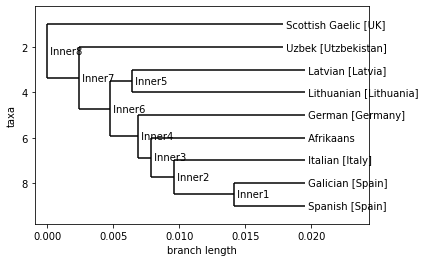

In [28]:
from Bio.Phylo.TreeConstruction import DistanceMatrix
import numpy as np

distM = [diccionario[key] for key in diccionario.keys()]
nombres = [str(key)[:-4] for key in diccionario.keys()]
distM = lower_triangular(distM)

distMatrix = DistanceMatrix(names=nombres, matrix=distM)
constructor = DistanceTreeConstructor()
UGMATree = constructor.upgma(distMatrix)

Phylo.draw(UGMATree)